### Problem (unicode1): Understanding Unicode

#### (a) What Unicode character does chr(0) return?
The null character (U+0000).

#### (b) How does this character's string representation (__repr__()) differ from its printed representation?
The string representation includes escape characters (e.g., "'\\x00'"), while the printed representation shows the character itself (which is invisible).

#### (c) What happens when this character occurs in text?
The null character can cause unexpected behavior in text processing, as it is often used as a string terminator in programming languages (such as C or C++). 
In Python, it can be included in strings, but its presence may lead to confusion or errors when manipulating or displaying the text.

In [8]:
from IPython.display import display

display(chr(0))

display(chr(0).__repr__())
print(chr(0))

display("this is a test" + chr(0) + "string")
print("this is a test" + chr(0) + "string")

'\x00'

"'\\x00'"

 


'this is a test\x00string'

this is a test string


### Problem (unicode2): Unicode Encodings

#### (a) What are some reasons to prefer training our tokenizer on UTF-8 encoded bytes, rather than UTF-16 or UTF-32? It may be helpful to compare the output of these encodings for various input strings.
- UTF-8 is more space-efficient for ASCII characters, as it uses a single byte for these characters, while UTF-16 uses two bytes and UTF-32 uses four bytes.
- Many existing text corpora and libraries are optimized for UTF-8, making it easier to integrate with other tools and datasets.
- Training on byte sequences allows the model to learn subword representations more effectively, as it can capture byte-level patterns that may be lost in character-level representations.

#### (b) Consider the following (incorrect) function, which is intended to decode a UTF-8 byte string into a Unicode string. Why is this function incorrect? Provide an example of an input byte string that yields incorrect results.
```python
def decode_utf8_bytes_to_str_wrong(bytestring: bytes):
  return "".join([bytes([b]).decode("utf-8") for b in bytestring])

print(decode_utf8_bytes_to_str_wrong("hello".encode("utf-8")))
```

The function is incorrect because it processes each byte individually, which wouldn't make sense because some bytes need to be decoded together to make a character.

#### (c) Give a two byte sequence that does not decode to any Unicode character(s).
b'\x80\x80'

In [ ]:
def decode_utf8_bytes_to_str_wrong(bytestring: bytes):
    return "".join([bytes([b]).decode("utf-8") for b in bytestring])


print(decode_utf8_bytes_to_str_wrong("hello".encode("utf-8")))

try:
    print(decode_utf8_bytes_to_str_wrong("🎉".encode("utf-8")))
except UnicodeDecodeError as e:
    print(f"Error decoding bytes: {e}")

try:
    b"\x80\x80".decode("utf-8")
except UnicodeDecodeError as e:
    print(f"Error decoding bytes: {e}")

hello
Error decoding bytes: 'utf-8' codec can't decode byte 0xf0 in position 0: unexpected end of data
Error decoding bytes: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte


### Problem (train_bpe_tinystories): BPE Training on TinyStories

#### (a) Train a byte-level BPE tokenizer on the TinyStories dataset, using a maximum vocabulary size of 10,000. Make sure to add the TinyStories `<|endoftext|>` special token to the vocabulary. Serialize the resulting vocabulary and merges to disk for further inspection. How many hours and memory did training take? What is the longest token in the vocabulary? Does it make sense?
Resource requirements: ≤ 30 minutes (no GPUs), ≤ 30GB RAM  
**Hint**  You should be able to get under 2 minutes for BPE training using multiprocessing during pretokenization and the following two facts:
- (a) The <|endoftext|> token delimits documents in the data files.
- (b) The <|endoftext|> token is handled as a special case before the BPE merges are applied.

On MacAir M4, training took approximately 50 seconds, and peak memory usage was around 2GB.  
The longest token in the vocabulary is: b' accomplishment'. It makes sense since it is a common word in the dataset.

#### (b) Profile your code. What part of the tokenizer training process takes the most time?
Using `scalene` to profile shows that `pretokenization` takes the most time(approximately 90%+ of the total training time).  
The printed text(cProfile) also shows the time needed to pretokenize takes the most time.

In [ ]:
import cProfile

from cs336_basics.bpe_tokenizer.encoder import train_bpe_tokenizer

input_path = "data/TinyStoriesV2-GPT4-valid.txt"
vocab_path = "data/TinyStoriesV2-GPT4_vocab.json"
merge_path = "data/TinyStoriesV2-GPT4_merges.txt"

profiler = cProfile.Profile()
profiler.enable()

tokenizer = train_bpe_tokenizer(
    input_path=input_path,
    vocab_size=10000,
    special_tokens=["<|endoftext|>"],
    save=True,
    vocab_path=vocab_path,
    merge_path=merge_path,
)

profiler.disable()
profiler.print_stats(sort="cumtime")

2025-08-16 18:13:09.505 | INFO     | cs336_basics.bpe_tokenizer.encoder:train_bpe_tokenizer:25 - Training BPE tokenizer on data/TinyStoriesV2-GPT4-valid.txt, vocab size: 10000, special tokens: ['<|endoftext|>']


Pre-tokenization took 0.48 seconds


2025-08-16 18:13:10.385 | INFO     | cs336_basics.bpe_tokenizer.encoder:train_bpe_tokenizer:32 - Trained BPE tokenizer with vocab size: 10000


vocab size: 10000, set vocab size: 10000
         1984031 function calls (1983696 primitive calls) in 0.923 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       25    0.000    0.000    0.671    0.027 connection.py:1134(wait)
        1    0.000    0.000    0.476    0.476 pretokenization.py:106(pretokenize_file)
        1    0.000    0.000    0.468    0.468 pool.py:738(__exit__)
        1    0.000    0.000    0.467    0.467 pool.py:654(terminate)
       14    0.000    0.000    0.448    0.032 connection.py:253(poll)
       15    0.000    0.000    0.441    0.029 util.py:197(__call__)
        1    0.000    0.000    0.440    0.440 pool.py:680(_terminate_pool)
        1    0.003    0.003    0.440    0.440 788761672.py:1(<module>)
       25    0.000    0.000    0.438    0.018 selectors.py:385(select)
       25    0.001    0.000    0.437    0.017 {method 'poll' of 'select.poll' objects}
       14    0.000    0.000    0.437    0.

In [ ]:
import cProfile

from cs336_basics.bpe_tokenizer.encoder import train_bpe_tokenizer

input_path = "data/TinyStoriesV2-GPT4-train.txt"
vocab_path = "data/TinyStoriesV2-GPT4_vocab.json"
merge_path = "data/TinyStoriesV2-GPT4_merges.txt"

profiler = cProfile.Profile()
profiler.enable()

tokenizer = train_bpe_tokenizer(
    input_path=input_path,
    vocab_size=10000,
    special_tokens=["<|endoftext|>"],
    save=True,
    vocab_path=vocab_path,
    merge_path=merge_path,
)

profiler.disable()
profiler.print_stats(sort="cumtime")
profiler.print_stats(sort="tottime")

2025-08-16 21:43:31.274 | INFO     | cs336_basics.bpe_tokenizer.encoder:train_bpe_tokenizer:25 - Training BPE tokenizer on data/TinyStoriesV2-GPT4-train.txt, vocab size: 10000, special tokens: ['<|endoftext|>'], num chunks: 8
2025-08-16 21:44:16.482 | INFO     | cs336_basics.bpe_tokenizer.encoder:train_bpe_tokenizer:32 - Trained BPE tokenizer with vocab size: 10000


vocab size: 10000, set vocab size: 10000
         5722411 function calls (5722270 primitive calls) in 45.257 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       69    0.000    0.000   98.016    1.421 connection.py:1134(wait)
       69    0.001    0.000   97.836    1.418 selectors.py:385(select)
       33    0.000    0.000   87.507    2.652 pool.py:500(_wait_for_updates)
       53    0.017    0.000   78.543    1.482 base_events.py:1954(_run_once)
       69   10.237    0.148   54.061    0.783 {method 'poll' of 'select.poll' objects}
      3/2    0.000    0.000   45.256   22.628 interactiveshell.py:3663(run_code)
        2    0.000    0.000   45.256   22.628 {built-in method builtins.exec}
        1    0.001    0.001   45.256   45.256 3166285396.py:1(<module>)
        1    0.232    0.232   45.194   45.194 trainer.py:112(train)
        1    0.000    0.000   43.886   43.886 pretokenization.py:109(pretokenize_file_to_counter

In [ ]:
from cs336_basics.bpe_tokenizer.encoder import load_bpe_tokenizer

vocab_path = "data/TinyStoriesV2-GPT4_vocab.json"
merge_path = "data/TinyStoriesV2-GPT4_merges.txt"
# find the longest vocab in tokenizer
tokenizer = load_bpe_tokenizer(
    vocab_path=vocab_path,
    merge_path=merge_path,
    special_tokens=["<|endoftext|>"],
)

longest_token = max(tokenizer.vocab.values(), key=len)
print(f"The longest token in the vocabulary is: {longest_token}")

The longest token in the vocabulary is: b' accomplishment'


In [ ]:
from cs336_basics.bpe_tokenizer.encoder import (
    encode_file,
    load_bpe_tokenizer,
)

input_path = f"data/TinyStoriesV2-GPT4-train.txt"
output_file = f"data/TinyStoriesV2-GPT4-train_encoded_10k.npy"

vocab_filepath = f"data/TinyStoriesV2-GPT4_vocab.json"
merge_filepath = f"data/TinyStoriesV2-GPT4_merges.txt"

tokenizer = load_bpe_tokenizer(
    vocab_path=vocab_filepath,
    merge_path=merge_filepath,
    special_tokens=["<|endoftext|>"],
)

encode_file(input_path, tokenizer, output_file, use_memmap=True)

2025-08-16 21:51:06.078 | INFO     | cs336_basics.bpe_tokenizer.encoder:encode_file:80 - Encoding file data/TinyStoriesV2-GPT4-train.txt using 8 processes...
2025-08-16 21:52:16.423 | INFO     | cs336_basics.bpe_tokenizer.encoder:encode_file:84 - Encoding completed. Saving to data/TinyStoriesV2-GPT4-train_encoded_10k.npy...
2025-08-16 21:52:29.206 | SUCCESS  | cs336_basics.bpe_tokenizer.encoder:encode_file:104 - Saved token array to data/TinyStoriesV2-GPT4-train_encoded_10k.npy


### Problem (train_bpe_expts_owt): BPE Training on OpenWebText

#### (a) Train a byte-level BPE tokenizer on the OpenWebText dataset, using a maximum vocabulary size of 32,000. Serialize the resulting vocabulary and merges to disk for further inspection. What is the longest token in the vocabulary? Does it make sense?
Resource requirements: ≤ 12 hours (no GPUs), ≤ 100GB RAM  

The longest token in the vocabulary is: `b'---------------------------'`. This makes sense, as long runs of hyphens are common as separators in web text, and BPE merges frequent patterns into single tokens.

#### (b) Compare and contrast the tokenizer that you get training on TinyStories versus OpenWebText.
- The tokenizer trained on TinyStories has a smaller vocabulary size (10,000) compared to the one trained on OpenWebText (32,000). 
- TinyStories has a more specialized vocabulary, focusing on the specific language and patterns found in children's stories, while OpenWebText has a broader vocabulary that captures a wider range of topics and styles found in web text.
- The TinyStories tokenizer tends to merge frequent, simple words and short phrases, resulting in tokens that are often common words or short expressions. In contrast, the OpenWebText tokenizer merges frequent patterns found on the web, such as long runs of hyphens, URLs, or special symbols, so the longest tokens may be web separators or long English words.
- In summary, the TinyStories tokenizer is simpler and more domain-specific, while the OpenWebText tokenizer is larger and more general-purpose, better suited for handling the diversity of real-world web data.

In [ ]:
from cs336_basics.bpe_tokenizer.encoder import train_bpe_tokenizer

input_path = "data/owt_train.txt"
vocab_path = "data/owt_vocab.json"
merge_path = "data/owt_merges.txt"

tokenizer = train_bpe_tokenizer(
    input_path=input_path,
    vocab_size=32_000,
    special_tokens=["<|endoftext|>"],
    save=True,
    vocab_path=vocab_path,
    merge_path=merge_path,
)

2025-08-16 20:31:41.674 | INFO     | cs336_basics.bpe_tokenizer.encoder:train_bpe_tokenizer:24 - Training BPE tokenizer on data/owt_train.txt, vocab size: 32000, special tokens: ['<|endoftext|>']
2025-08-16 20:40:56.631 | INFO     | cs336_basics.bpe_tokenizer.encoder:train_bpe_tokenizer:31 - Trained BPE tokenizer with vocab size: 32000


vocab size: 32000, set vocab size: 32000


In [ ]:
from cs336_basics.bpe_tokenizer.encoder import load_bpe_tokenizer

vocab_path = "data/owt_vocab.json"
merge_path = "data/owt_merges.txt"
# find the longest vocab in tokenizer
tokenizer = load_bpe_tokenizer(
    vocab_path=vocab_path,
    merge_path=merge_path,
    special_tokens=["<|endoftext|>"],
)

longest_token = max(tokenizer.vocab.values(), key=len)
print(f"The longest token in the vocabulary is: {longest_token}")

The longest token in the vocabulary is: b'---------------------------'


### Memory considerations.
> Suppose we want to tokenize a large text file that we cannot fit in memory. To efficiently tokenize this large file (or any other stream of data), we need to break it up into manageable chunks and process each chunk in-turn, so that the memory complexity is constant as opposed to linear in the size of the text. In doing so, we need to make sure that a token doesn't cross chunk boundaries, else we'll get a different tokenization than the naïve method of tokenizing the entire sequence in-memory.

To verify chunking strategy is working correctly, compare the tokenization results of the chunked approach with the naïve approach on smaller, manageable text files. By ensuring that both methods produce the same tokenization for these smaller files, we can gain confidence that our chunking strategy will work for larger files as well.

In [ ]:
import os
import time
import numpy as np
from cs336_basics.bpe_tokenizer.encoder import (
    encode_file,
    encode_file_streaming,
    encode_file_naive,
    load_bpe_tokenizer,
)


def check_equal(array1, array2):
    if np.array_equal(array1, array2):
        print(f"✅ {array1} and {array2} are identical!")
    else:
        print(f"❌ {array1} and {array2} are different!")


class Timer:
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        print(f"Elapsed: {self.end - self.start:.2f} seconds")


train_or_valid = "valid"
input_path = f"data/TinyStoriesV2-GPT4-{train_or_valid}.txt"
output_file1 = f"data/TinyStoriesV2-GPT4-{train_or_valid}_encoded_10k1.npy"
output_file2 = f"data/TinyStoriesV2-GPT4-{train_or_valid}_encoded_10k2.npy"
output_file3 = f"data/TinyStoriesV2-GPT4-{train_or_valid}_encoded_10k3.npy"
output_file4 = f"data/TinyStoriesV2-GPT4-{train_or_valid}_encoded_10k4.npy"
output_file5 = f"data/TinyStoriesV2-GPT4-{train_or_valid}_encoded_10k5.npy"

vocab_filepath = "data/TinyStoriesV2-GPT4_vocab.json"
merge_filepath = "data/TinyStoriesV2-GPT4_merges.txt"

tokenizer = load_bpe_tokenizer(
    vocab_path=vocab_filepath,
    merge_path=merge_filepath,
    special_tokens=["<|endoftext|>"],
)
with Timer():
    encode_file(input_path, tokenizer, output_file1)
with Timer():
    encode_file(input_path, tokenizer, output_file2, use_memmap=True)
with Timer():
    encode_file_naive(input_path, tokenizer, output_file3)
with Timer():
    encode_file_naive(input_path, tokenizer, output_file4, use_memmap=True)
with Timer():
    encode_file_streaming(input_path, tokenizer, output_file5)

array1 = np.load(output_file1)
array2 = np.memmap(output_file2, dtype=np.uint16, mode="r")
array3 = np.load(output_file3)
array4 = np.memmap(output_file4, dtype=np.uint16, mode="r")
array5 = np.memmap(output_file5, dtype=np.uint16, mode="r")

check_equal(array1, array2)
check_equal(array3, array4)
check_equal(array1, array3)
check_equal(array1, array5)

os.remove(output_file1)
os.remove(output_file2)
os.remove(output_file3)
os.remove(output_file4)
os.remove(output_file5)

2025-08-17 11:19:08.391 | INFO     | cs336_basics.bpe_tokenizer.encoder:encode_file:90 - Encoding file data/TinyStoriesV2-GPT4-valid.txt using 8 chunks...
2025-08-17 11:19:08.755 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:66 - Tokenized chunk 2813541-5625758, got 682990 tokens
2025-08-17 11:19:08.788 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:66 - Tokenized chunk 0-2813541, got 683867 tokens
2025-08-17 11:19:08.796 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:66 - Tokenized chunk 19690315-22502601, got 682743 tokens
2025-08-17 11:19:08.798 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:66 - Tokenized chunk 5625758-8438541, got 683132 tokens
2025-08-17 11:19:08.812 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:66 - Tokenized chunk 11252559-14064356, got 681943 tokens
2025-08-17 11:19:08.815 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:66 - Tokenized chunk 8438541-11252559, got 68

Elapsed: 0.61 seconds


2025-08-17 11:19:09.422 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:66 - Tokenized chunk 0-2813541, got 683867 tokens
2025-08-17 11:19:09.425 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:66 - Tokenized chunk 2813541-5625758, got 682990 tokens
2025-08-17 11:19:09.446 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:66 - Tokenized chunk 16877372-19690315, got 683618 tokens
2025-08-17 11:19:09.448 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:66 - Tokenized chunk 14064356-16877372, got 684968 tokens
2025-08-17 11:19:09.453 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:66 - Tokenized chunk 8438541-11252559, got 682702 tokens
2025-08-17 11:19:09.455 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:66 - Tokenized chunk 5625758-8438541, got 683132 tokens
2025-08-17 11:19:09.475 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:66 - Tokenized chunk 19690315-22502601, got 682743 token

Elapsed: 0.66 seconds


2025-08-17 11:19:11.152 | INFO     | cs336_basics.bpe_tokenizer.encoder:encode_file_naive:172 - Encoding completed. Saving to data/TinyStoriesV2-GPT4-valid_encoded_10k3.npy...
2025-08-17 11:19:11.241 | SUCCESS  | cs336_basics.bpe_tokenizer.encoder:encode_file_naive:188 - Saved token array to data/TinyStoriesV2-GPT4-valid_encoded_10k3.npy
2025-08-17 11:19:11.262 | INFO     | cs336_basics.bpe_tokenizer.encoder:encode_file_naive:168 - Encoding file data/TinyStoriesV2-GPT4-valid.txt serially...


Elapsed: 1.59 seconds


2025-08-17 11:19:12.642 | INFO     | cs336_basics.bpe_tokenizer.encoder:encode_file_naive:172 - Encoding completed. Saving to data/TinyStoriesV2-GPT4-valid_encoded_10k4.npy...
2025-08-17 11:19:12.758 | SUCCESS  | cs336_basics.bpe_tokenizer.encoder:encode_file_naive:188 - Saved token array to data/TinyStoriesV2-GPT4-valid_encoded_10k4.npy
2025-08-17 11:19:12.768 | INFO     | cs336_basics.bpe_tokenizer.encoder:encode_file_streaming:140 - Encoding file data/TinyStoriesV2-GPT4-valid.txt using 1 chunks...
2025-08-17 11:19:12.768 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:encode_file_streaming:147 - Processing chunks 0 to 1 / 1...


Elapsed: 1.52 seconds


2025-08-17 11:19:14.253 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:66 - Tokenized chunk 0-22502601, got 5465963 tokens
2025-08-17 11:19:14.457 | SUCCESS  | cs336_basics.bpe_tokenizer.encoder:encode_file_streaming:158 - Saved token array to data/TinyStoriesV2-GPT4-valid_encoded_10k5.npy


Elapsed: 1.71 seconds
✅ [117 861 491 ... 377 375  46] and [117 861 491 ... 377 375  46] are identical!
✅ [117 861 491 ... 377 375  46] and [117 861 491 ... 377 375  46] are identical!
✅ [117 861 491 ... 377 375  46] and [117 861 491 ... 377 375  46] are identical!
✅ [117 861 491 ... 377 375  46] and [117 861 491 ... 377 375  46] are identical!


In [ ]:
import os
import time
import numpy as np
from cs336_basics.bpe_tokenizer.encoder import (
    encode_file,
    encode_file_streaming,
    encode_file_naive,
    load_bpe_tokenizer,
)


def check_equal(array1, array2):
    if np.array_equal(array1, array2):
        print(f"✅ {array1} and {array2} are identical!")
    else:
        print(f"❌ {array1} and {array2} are different!")
        diff = np.setdiff1d(array1, array2)
        print(f"Difference (in array1 but not in array2): {diff}")


class Timer:
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        print(f"Elapsed: {self.end - self.start:.2f} seconds")


train_or_valid = "train"
input_path = f"data/TinyStoriesV2-GPT4-{train_or_valid}.txt"
output_file1 = f"data/TinyStoriesV2-GPT4-{train_or_valid}_encoded_10k1.npy"
output_file5 = f"data/TinyStoriesV2-GPT4-{train_or_valid}_encoded_10k5.npy"

vocab_filepath = "data/TinyStoriesV2-GPT4_vocab.json"
merge_filepath = "data/TinyStoriesV2-GPT4_merges.txt"

tokenizer = load_bpe_tokenizer(
    vocab_path=vocab_filepath,
    merge_path=merge_filepath,
    special_tokens=["<|endoftext|>"],
)
with Timer():
    encode_file(input_path, tokenizer, output_file1)
with Timer():
    encode_file_streaming(input_path, tokenizer, output_file5, 100)

array1 = np.load(output_file1)
array5 = np.memmap(output_file5, dtype=np.uint16, mode="r")

check_equal(array1, array5)

os.remove(output_file1)
os.remove(output_file5)

2025-08-17 12:32:06.458 | INFO     | cs336_basics.bpe_tokenizer.encoder:encode_file:94 - Encoding file data/TinyStoriesV2-GPT4-train.txt using 8 chunks...
2025-08-17 12:32:06.610 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:60 - Tokenizing bytes 278469249-556938507, total 265.57 MB...
2025-08-17 12:32:06.629 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:60 - Tokenizing bytes 0-278469249, total 265.57 MB...
2025-08-17 12:32:06.632 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:60 - Tokenizing bytes 1113876594-1392345974, total 265.57 MB...
2025-08-17 12:32:06.633 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:60 - Tokenizing bytes 556938507-835407773, total 265.57 MB...
2025-08-17 12:32:06.635 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:60 - Tokenizing bytes 835407773-1113876594, total 265.57 MB...
2025-08-17 12:32:06.638 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:60 - Tokenizing by

Elapsed: 87.73 seconds


2025-08-17 12:33:34.213 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:encode_file_streaming:150 - Processing chunks 0 to 16 / 21...
2025-08-17 12:33:34.353 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:60 - Tokenizing bytes 106084188-212167479, total 101.17 MB...
2025-08-17 12:33:34.353 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:60 - Tokenizing bytes 424334498-530417596, total 101.17 MB...
2025-08-17 12:33:34.353 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:60 - Tokenizing bytes 636501360-742584451, total 101.17 MB...
2025-08-17 12:33:34.353 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:60 - Tokenizing bytes 0-106084188, total 101.17 MB...
2025-08-17 12:33:34.354 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:60 - Tokenizing bytes 318250584-424334498, total 101.17 MB...
2025-08-17 12:33:34.355 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:60 - Tokenizing bytes 742584451-848668118,

Elapsed: 57.12 seconds
✅ [ 10 429 438 ... 316  89 111] and [ 10 429 438 ... 316  89 111] are identical!


### Problem (tokenizer_experiments): Experiments with tokenizers

#### (a) Sample 10 documents from TinyStories and OpenWebText. Using your previously-trained TinyStories and OpenWebText tokenizers (10K and 32K vocabulary size, respectively), encode these sampled documents into integer IDs. What is each tokenizer's compression ratio (bytes/token)?
TinyStories tokenizers compression ratio: 4.03
OpenWebText tokenizers compression ratio: 4.20

In [ ]:
from cs336_basics.bpe_tokenizer.encoder import load_bpe_tokenizer, sample_from_file


def calculate_compression_ratio(document_name, desired_num_chunks: int):
    if document_name == "TinyStoriesV2-GPT4":
        input_path = f"data/{document_name}-train.txt"
    elif document_name == "owt":
        input_path = f"data/{document_name}_train.txt"
    vocab_path = f"data/{document_name}_vocab.json"
    merge_path = f"data/{document_name}_merges.txt"

    sample_size = 10
    special_tokens = ["<|endoftext|>"]

    tokenizer = load_bpe_tokenizer(vocab_path, merge_path, special_tokens)
    samples = sample_from_file(input_path, sample_size, special_tokens, desired_num_chunks)
    token_ids = tokenizer.encode_iterable(samples)

    original_size = sum(len(sample.encode("utf-8")) for sample in samples)
    compressed_size = 0
    for _ in token_ids:
        # Each token ID is a single integer, so we count each as 1 byte
        compressed_size += 1
    return original_size / compressed_size if compressed_size > 0 else 0


tiny_stories_ratio = calculate_compression_ratio("TinyStoriesV2-GPT4", 8)
print(f"TinyStories compression ratio: {tiny_stories_ratio:.2f}")

owt_ratio = calculate_compression_ratio("owt", 64)
print(f"OpenWebText compression ratio: {owt_ratio:.2f}")

TinyStories compression ratio: 4.03
OpenWebText compression ratio: 4.20


#### (b) What happens if you tokenize your OpenWebText sample with the TinyStories tokenizer? Compare the compression ratio and/or qualitatively describe what happens.
OpenWebText compression ratio using TinyStories tokenizer: 3.22. The compression ratio drops significantly, indicating that the TinyStories tokenizer is less effective at compressing the OpenWebText dataset compared to its native tokenizer. That is because the TinyStories tokenizer is more specialized for shorter, more narrative texts, while OpenWebText contains a wider variety of content and styles.

In [ ]:
from cs336_basics.bpe_tokenizer.encoder import load_bpe_tokenizer, sample_from_file


input_path = f"data/owt_train.txt"
vocab_path = f"data/TinyStoriesV2-GPT4_vocab.json"
merge_path = f"data/TinyStoriesV2-GPT4_merges.txt"

sample_size = 10
special_tokens = ["<|endoftext|>"]

tokenizer = load_bpe_tokenizer(vocab_path, merge_path, special_tokens)
samples = sample_from_file(input_path, sample_size, special_tokens, 64)
token_ids = tokenizer.encode_iterable(samples)

original_size = sum(len(sample.encode("utf-8")) for sample in samples)
compressed_size = 0
for _ in token_ids:
    # Each token ID is a single integer, so we count each as 1 byte
    compressed_size += 1
compressed_ratio = original_size / compressed_size if compressed_size > 0 else 0

print(f"OpenWebText compression ratio using TinyStories tokenizer: {compressed_ratio:.2f}")

OpenWebText compression ratio using TinyStories tokenizer: 3.22


#### (c) Estimate the throughput of your tokenizer (e.g., in bytes/second). How long would it take to tokenize the Pile dataset (825GB of text)?
Mean throughputs for TinyStories: 16170108.27 bytes/second. Time needed to process 825GB with TinyStories: 54782.38 seconds(roughly 15.2 hours).  
Mean throughputs for OpenWebText: 12334632.05 bytes/second. Time needed to process 825GB with OpenWebText: 71817.06 seconds(roughly 19.9 hours).

In [ ]:
import time
import numpy as np

from cs336_basics.bpe_tokenizer.encoder import load_bpe_tokenizer


def calculate_throughput(document_name, read_mb: int = 128):
    if document_name == "TinyStoriesV2-GPT4":
        input_path = f"data/{document_name}-train.txt"
    elif document_name == "owt":
        input_path = f"data/{document_name}_train.txt"
    vocab_path = f"data/{document_name}_vocab.json"
    merge_path = f"data/{document_name}_merges.txt"

    special_tokens = ["<|endoftext|>"]
    tokenizer = load_bpe_tokenizer(vocab_path, merge_path, special_tokens)

    read_bytes = read_mb * 1024 * 1024  # Read specified MB

    with open(input_path, "r", encoding="utf-8") as f:
        text = f.read(read_bytes)

    start_time = time.time()
    _ = list(tokenizer.encode_iterable([text]))
    end_time = time.time()

    return read_bytes / (end_time - start_time) if end_time - start_time > 0 else 0


tiny_stories_throughputs = []
owt_throughputs = []

for mb in [128, 256, 512]:
    tiny_stories_throughput = calculate_throughput("TinyStoriesV2-GPT4", read_mb=mb)
    tiny_stories_throughputs.append(tiny_stories_throughput)
    print(f"TinyStories throughput: {tiny_stories_throughput:.2f} bytes/second")

    owt_throughput = calculate_throughput("owt", read_mb=mb)
    owt_throughputs.append(owt_throughput)
    print(f"OpenWebText throughput: {owt_throughput:.2f} bytes/second")

mean_tiny_stories_throughput = np.mean(tiny_stories_throughputs)
print(f"Mean throughputs for TinyStories: {mean_tiny_stories_throughput:.2f} bytes/second")
time_needed_for_825GB = 825 * 1024 * 1024 * 1024 / mean_tiny_stories_throughput
print(f"Time needed to process 825GB with TinyStories: {time_needed_for_825GB:.2f} seconds")

mean_owt_throughput = np.mean(owt_throughputs)
print(f"Mean throughputs for OpenWebText: {mean_owt_throughput:.2f} bytes/second")
time_needed_for_825GB = 825 * 1024 * 1024 * 1024 / mean_owt_throughput
print(f"Time needed to process 825GB with OpenWebText: {time_needed_for_825GB:.2f} seconds")

TinyStories throughput: 15806786.31 bytes/second
OpenWebText throughput: 11361867.14 bytes/second
TinyStories throughput: 16391106.94 bytes/second
OpenWebText throughput: 12586252.07 bytes/second
TinyStories throughput: 16312431.57 bytes/second
OpenWebText throughput: 13055776.93 bytes/second
Mean throughputs for TinyStories: 16170108.27 bytes/second
Time needed to process 825GB with TinyStories: 54782.38 seconds
Mean throughputs for OpenWebText: 12334632.05 bytes/second
Time needed to process 825GB with OpenWebText: 71817.06 seconds


#### (d) Using your TinyStories and OpenWebText tokenizers, encode the respective training and development datasets into a sequence of integer token IDs. We'll use this later to train our language model. We recommend serializing the token IDs as a NumPy array of datatype uint16. Why is uint16 an appropriate choice?
Using `uint16` is appropriate because:
1. It provides a sufficient range to represent all possible token IDs (up to 65535), which is more than enough for most tokenizers.
2. It uses less memory compared to larger integer types (like `int32` or `int64`), making it more efficient for storing large arrays of token IDs.
3. Many NLP tasks involve working with large datasets, and reducing memory usage can lead to faster training times and lower resource consumption.

In [17]:
from cs336_basics.bpe_tokenizer.encoder import (
    encode_file,
    load_bpe_tokenizer,
)

vocab_filepath = f"data/TinyStoriesV2-GPT4_vocab.json"
merge_filepath = f"data/TinyStoriesV2-GPT4_merges.txt"
tokenizer = load_bpe_tokenizer(
    vocab_path=vocab_filepath,
    merge_path=merge_filepath,
    special_tokens=["<|endoftext|>"],
)

for train_or_valid in ["valid", "train"]:
    input_path = f"data/TinyStoriesV2-GPT4-{train_or_valid}.txt"
    output_file = f"data/TinyStoriesV2-GPT4-{train_or_valid}_encoded_10k.npy"

    encode_file(input_path, tokenizer, output_file, use_memmap=True)

2025-08-16 23:59:06.769 | INFO     | cs336_basics.bpe_tokenizer.encoder:encode_file:89 - Encoding file data/TinyStoriesV2-GPT4-valid.txt using 8 chunks...
2025-08-16 23:59:07.280 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:65 - Tokenized chunk 5625758-8438541, got 683132 tokens
2025-08-16 23:59:07.292 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:65 - Tokenized chunk 0-2813541, got 683867 tokens
2025-08-16 23:59:07.295 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:65 - Tokenized chunk 14064356-16877372, got 684968 tokens
2025-08-16 23:59:07.301 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:65 - Tokenized chunk 8438541-11252559, got 682702 tokens
2025-08-16 23:59:07.309 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:65 - Tokenized chunk 11252559-14064356, got 681943 tokens
2025-08-16 23:59:07.311 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:65 - Tokenized chunk 2813541-5625758, got 68

In [ ]:
from cs336_basics.bpe_tokenizer.encoder import (
    encode_file,
    load_bpe_tokenizer,
)

vocab_filepath = f"data/owt_vocab.json"
merge_filepath = f"data/owt_merges.txt"
tokenizer = load_bpe_tokenizer(
    vocab_path=vocab_filepath,
    merge_path=merge_filepath,
    special_tokens=["<|endoftext|>"],
)

for train_or_valid in ["valid", "train"]:
    input_path = f"data/owt_{train_or_valid}.txt"
    output_file = f"data/owt_{train_or_valid}_encoded_32k.npy"

    encode_file(input_path, tokenizer, output_file, use_memmap=True, desired_num_chunks=64)

2025-08-17 00:03:06.649 | INFO     | cs336_basics.bpe_tokenizer.encoder:encode_file:89 - Encoding file data/owt_valid.txt using 64 chunks...
2025-08-17 00:03:07.702 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:65 - Tokenized chunk 0-4534646, got 1028482 tokens
2025-08-17 00:03:07.733 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:65 - Tokenized chunk 18128078-22660565, got 1028150 tokens
2025-08-17 00:03:07.733 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:65 - Tokenized chunk 45313693-49843604, got 1034177 tokens
2025-08-17 00:03:07.757 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:65 - Tokenized chunk 9069135-13595080, got 1045635 tokens
2025-08-17 00:03:07.758 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:65 - Tokenized chunk 27188872-31721170, got 1040461 tokens
2025-08-17 00:03:07.815 | DEBUG    | cs336_basics.bpe_tokenizer.encoder:tokenize_chunk:65 - Tokenized chunk 54375317-58913104, got 1037925

### Einsum
> It turns out almost all operations in machine learning are some combination of dimension juggling and tensor contraction with the occasional (usually pointwise) nonlinear function. This means that a lot of your code can be more readable and flexible when using einsum notation.

In [ ]:
# Example (einstein_example1): Batched matrix multiplication with einops.einsum

import torch
from einops import rearrange, einsum

D = torch.randn(32, 128, 64)
A = torch.randn(128, 64)

## Basic implementation
Y = D @ A.T
print(Y.shape)
# Hard to tell the input and output shapes and what they mean.
# What shapes can D and A have, and do any of these have unexpected behavior?
## Einsum is self-documenting and robust
# D A -> Y
Y = einsum(D, A, "batch sequence d_in, d_out d_in -> batch sequence d_out")
print(Y.shape)
## Or, a batched version where D can have any leading dimensions but A is constrained.
Y = einsum(D, A, "... d_in, d_out d_in -> ... d_out")
print(Y.shape)

torch.Size([32, 128, 128])
torch.Size([32, 128, 128])
torch.Size([32, 128, 128])


In [ ]:
# Example (einstein_example2): Broadcasted operations with einops.rearrange

import torch
from einops import rearrange, einsum

"""
We have a batch of images, and for each image we want to generate 10 dimmed versions based on some scaling factor:
"""
images = torch.randn(64, 128, 128, 3)  # (batch, height, width, channel)
dim_by = torch.linspace(start=0.0, end=1.0, steps=10)
## Reshape and multiply
dim_value = rearrange(dim_by, "dim_value -> 1 dim_value 1 1 1")
images_rearr = rearrange(images, "b height width channel -> b 1 height width channel")
dimmed_images = images_rearr * dim_value
print(dimmed_images.shape)
## Or in one go:
dimmed_images = einsum(
    images,
    dim_by,
    "batch height width channel, dim_value -> batch dim_value height width channel",
)
print(dimmed_images.shape)

torch.Size([64, 10, 128, 128, 3])
torch.Size([64, 10, 128, 128, 3])


In [ ]:
# Example (einstein_example3): Pixel mixing with einops.rearrange

import torch
import einx
from einops import rearrange, einsum

"""
Suppose we have a batch of images represented as a tensor of shape (batch, height, width,
channel), and we want to perform a linear transformation across all pixels of the image, but this
transformation should happen independently for each channel. Our linear transformation is
represented as a matrix B of shape (height * width, height * width).
"""
channels_last = torch.randn(64, 32, 32, 3)  # (batch, height, width, channel)
B = torch.randn(32 * 32, 32 * 32)  # (pixel_out, pixel_in)
print(channels_last.shape, B.shape)
## Rearrange an image tensor for mixing across all pixels
# (batch, height * width, channel)
channels_last_flat = channels_last.view(-1, channels_last.size(1) * channels_last.size(2), channels_last.size(3))
print(channels_last_flat.shape)
# (batch, channel, height * width)
channels_first_flat = channels_last_flat.transpose(1, 2)
print(channels_first_flat.shape)
# (batch, channel, height * width)
channels_first_flat_transformed = channels_first_flat @ B.T
print(channels_first_flat_transformed.shape)
# (batch, height * width, channel)
channels_last_flat_transformed = channels_first_flat_transformed.transpose(1, 2)
print(channels_last_flat_transformed.shape)
# (batch, height, width, channel)
channels_last_transformed = channels_last_flat_transformed.view(*channels_last.shape)
print(channels_last_transformed.shape)

"""
Instead, using einops:
"""
height = width = 32
## Rearrange replaces clunky torch view + transpose
channels_first = rearrange(channels_last, "batch height width channel -> batch channel (height width)")
print(channels_first.shape)
channels_first_transformed = einsum(
    channels_first,
    B,
    "batch channel pixel_in, pixel_out pixel_in -> batch channel pixel_out",
)
print(channels_first_transformed.shape)
channels_last_transformed = rearrange(
    channels_first_transformed,
    "batch channel (height width) -> batch height width channel",
    height=height,
    width=width,
)
print(channels_last_transformed.shape)
"""
Or, if you're feeling crazy: all in one go using einx.dot (einx equivalent of einops.einsum)
"""
height = width = 32
channels_last_transformed = einx.dot(
    "batch row_in col_in channel, (row_out col_out) (row_in col_in)" "-> batch row_out col_out channel",
    channels_last,
    B,
    col_in=width,
    col_out=width,
)
print(channels_last_transformed.shape)

torch.Size([64, 32, 32, 3]) torch.Size([1024, 1024])
torch.Size([64, 1024, 3])
torch.Size([64, 3, 1024])
torch.Size([64, 3, 1024])
torch.Size([64, 1024, 3])
torch.Size([64, 32, 32, 3])
torch.Size([64, 3, 1024])
torch.Size([64, 3, 1024])
torch.Size([64, 32, 32, 3])
torch.Size([64, 32, 32, 3])


### Problem (transformer_accounting): Transformer LM resource accounting

#### (a) Consider GPT-2 XL, which has the following configuration:
- $vocab_size: 50,257$  
- $context_length: 1,024$  
- $num_layers: 48$  
- $d_model: 1,600$  
- $num_heads: 25$  
- $d_ff: 6,400$  
Suppose we constructed our model using this configuration. How many trainable parameters
would our model have? Assuming each parameter is represented using single-precision floating point, how much memory is required to just load this model?

Embedding: $50257 \times 1600[wte] + 1024 \times 1600[wpe]$  
Transformer blocks: $48 \times ((1600 + 1600)[ln\_1] + (4800 \times 1600 + 4800)[c\_attn] + (1600 \times 1600 + 1600)[c\_proj] + (1600 + 1600)[ln\_2] + (6400 \times 1600 + 6400)[c\_fc] + (1600 \times 6400 + 1600)[c\_proj])$  
LayerNorm: $1600 + 1600$  
Linear: $1600 \times 50257$  
Total trainable parameters: $1,557,611,200$  (Linear parameters shares weights with wte, so only count once)
Memory required: $1,557,611,200 \times 4$ bytes = $6,230,444,800$ bytes (approximately 5.80 GB).

In [ ]:
from transformers import GPT2Config, GPT2LMHeadModel

embedding_parameters = 50257 * 1600 + 1024 * 1600
transformer_block_parameters = 48 * (
    (1600 + 1600)
    + (4800 * 1600 + 4800)
    + (1600 * 1600 + 1600)
    + (1600 + 1600)
    + (6400 * 1600 + 6400)
    + (1600 * 6400 + 1600)
)
layernorm_parameters = 1600 + 1600
linear_parameters = 1600 * 50257
total_parameters = embedding_parameters + transformer_block_parameters + layernorm_parameters + linear_parameters
# Exclude the final linear layer since it shares weights with the embedding layer
total_trainable_parameters = total_parameters - linear_parameters

print(f"Total parameters: {total_parameters:,}, Trainable parameters: {total_trainable_parameters:,}")

config = GPT2Config(
    vocab_size=50257,
    n_positions=1024,  # context length
    n_layer=48,  # num_layers
    n_embd=1600,  # d_model
    n_head=25,  # num_heads
    n_inner=6400,  # d_ff (feed-forward dimension, usually 4 * d_model for GPT-2 models)
)
model = GPT2LMHeadModel(config)
print(model.modules)
print(f"Model has {model.num_parameters(only_trainable=True):,} parameters.")

print(
    f"Memory required: {model.num_parameters(only_trainable=True) * 4:,} bytes = {model.num_parameters(only_trainable=True) * 4 / (1024 ** 3):.2f} GB"
)

Total parameters: 1,638,022,400, Trainable parameters: 1,557,611,200
<bound method Module.modules of GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=4800, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=1600)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=6400, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=6400)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): 

#### (b) Identify the matrix multiplies required to complete a forward pass of our GPT-2 XL-shaped model. How many FLOPs do these matrix multiplies require in total? Assume that our input sequence has context_length tokens.
Deliverable: A list of matrix multiplies (with descriptions), and the total number of FLOPs required.  

> **Resource accounting**. It is useful to be able to understand how the various parts of the Transformer consume compute and memory. We will go through the steps to do some basic "FLOPs accounting". The vast majority of FLOPS in a Transformer are matrix multiplies, so our core approach is simple:  
> 
> 1. Write down all the matrix multiplies in a Transformer forward pass.  
> 2. Convert each matrix multiply into FLOPs required.  
> 
> For this second step, the following fact will be useful:  
> **Rule:** $A \in \mathbb{R}^{m \times n}$ and $B \in \mathbb{R}^{n \times p}$, the matrix-matrix product $AB$ requires $2mnp$ FLOPs.  
> To see this, note that $(AB)[i, j] = A[i, :] · B[:, j]$, and that this dot product requires $n$ additions and $n$ multiplications ($2n$ FLOPs). Then, since the matrix-matrix product $AB$ has $m \times p$ entries, the total number of FLOPS is $(2n)(mp) = 2mnp$.  

Embedding layer requires no matrix multiplications but only look up the table.  
**Main matrix multiplies per Transformer block:**
1. **QKV projection (`c_attn`)**:  
   - Shape: (context_length, d_model) × (d_model, 3 × d_model)  
   - FLOPs: $2 \times 1024 \times 1600 \times 4800$

2. **QK^T (attention scores)**:  
   - Shape: (context_length, d_k) × (d_k, context_length), per head, d_k = d_model / num_heads = 64  
   - FLOPs: $2 \times 25 \times 1024 \times 64 \times 1024$

3. **Attention weights × V**:  
   - Shape: (context_length, context_length) × (context_length, d_k), per head  
   - FLOPs: $2 \times 25 \times 1024 \times 1024 \times 64$

4. **Output projection (`c_proj`)**:  
   - Shape: (context_length, d_model) × (d_model, d_model)  
   - FLOPs: $2 \times 1024 \times 1600 \times 1600$

5. **MLP first layer (`c_fc`)**:  
   - Shape: (context_length, d_model) × (d_model, d_ff)  
   - FLOPs: $2 \times 1024 \times 1600 \times 6400$

6. **MLP second layer (`c_proj`)**:  
   - Shape: (context_length, d_ff) × (d_ff, d_model)  
   - FLOPs: $2 \times 1024 \times 6400 \times 1600$

**Output layer:**
- Shape: (context_length, d_model) × (d_model, vocab_size)  
- FLOPs: $2 \times 1024 \times 1600 \times 50257$

---
**Grand total:**  
$\boxed{3,506,703,564,800}$ FLOPs per forward pass

In [ ]:
from collections import namedtuple

ModelConfig = namedtuple(
    "ModelConfig", ["name", "vocab_size", "context_length", "num_layers", "d_model", "num_heads", "d_ff"]
)


def calculate_flops(vocab_size, context_length, num_layers, d_model, num_heads, d_ff):
    flops = []
    # (context_length, d_model) × (d_model, 3 × d_model)
    qkv_projection = 2 * context_length * d_model * (3 * d_model)
    flops.append(("QKV projection", qkv_projection))

    # (context_length, d_k) × (d_k, context_length), per head, d_k = d_model / num_heads
    qk_t = 2 * num_heads * context_length * (d_model // num_heads) * context_length
    flops.append(("QK^T", qk_t))

    # (context_length, context_length) × (context_length, d_k), per head
    attention_score = 2 * num_heads * context_length * context_length * (d_model // num_heads)
    flops.append(("Attention score", attention_score))

    # (context_length, d_model) × (d_model, d_model)
    c_proj_1 = 2 * context_length * d_model * d_model
    flops.append(("C_proj_1", c_proj_1))

    flops.append(("[Attention mechanism]", qkv_projection + qk_t + attention_score))

    # (context_length, d_model) × (d_model, d_ff)
    c_fc = 2 * context_length * d_model * d_ff
    flops.append(("C_fc", c_fc))

    # (context_length, d_ff) × (d_ff, d_model)
    c_proj_2 = 2 * context_length * d_ff * d_model
    flops.append(("C_proj_2", c_proj_2))

    transformer_block = qkv_projection + qk_t + attention_score + c_proj_1 + c_fc + c_proj_2
    flops.append(("[Transformer block]", transformer_block))

    flops.append(("[Total Transformer blocks]", transformer_block * num_layers))

    # (context_length, d_model) × (d_model, vocab_size)
    output_layer = 2 * context_length * d_model * vocab_size
    flops.append(("Output layer", output_layer))

    maxlen = max(len(name) for name, _ in flops)
    for name, count in flops:
        print(f"{name:<{maxlen}}: {count:,}")

    total_flops = transformer_block * num_layers + output_layer
    print(f"Each token: {total_flops:,}")
    print("Proportions:")
    print(
        f"Attention: {100 * (qkv_projection + qk_t + attention_score + c_proj_1) * num_layers / total_flops:.2f}% [QKV projection: {100 * qkv_projection * num_layers / total_flops:.2f}%, QK^T: {100 * qk_t * num_layers / total_flops:.2f}%, Attention score: {100 * attention_score * num_layers / total_flops:.2f}%, (Attention mechanism: {100 * (qkv_projection + qk_t + attention_score) * num_layers / total_flops:.2f}%) C_proj_1: {100 * c_proj_1 * num_layers / total_flops:.2f}%]"
    )
    print(
        f"MLP: {100 * (c_fc + c_proj_2) * num_layers / total_flops:.2f}% [C_fc: {100 * c_fc * num_layers / total_flops:.2f}%, C_proj_2: {100 * c_proj_2 * num_layers / total_flops:.2f}%]"
    )
    print(f"Output layer: {100 * output_layer / total_flops:.2f}%")


GPT2_XL = ModelConfig(
    name="GPT2_XL", vocab_size=50257, context_length=1024, num_layers=48, d_model=1600, num_heads=25, d_ff=6400
)
GPT2_small = ModelConfig(
    name="GPT2_small", vocab_size=50257, context_length=1024, num_layers=12, d_model=768, num_heads=12, d_ff=3072
)
GPT2_medium = ModelConfig(
    name="GPT2_medium", vocab_size=50257, context_length=1024, num_layers=24, d_model=1024, num_heads=16, d_ff=4096
)
GPT2_large = ModelConfig(
    name="GPT2_large", vocab_size=50257, context_length=1024, num_layers=36, d_model=1280, num_heads=20, d_ff=5120
)

GPT2_XL_modified = ModelConfig(
    name="GPT2_XL_modified",
    vocab_size=50257,
    context_length=16384,
    num_layers=48,
    d_model=1600,
    num_heads=25,
    d_ff=6400,
)

for config in [GPT2_XL, GPT2_small, GPT2_medium, GPT2_large, GPT2_XL_modified]:
    print(f"Config: {config}")
    calculate_flops(
        config.vocab_size, config.context_length, config.num_layers, config.d_model, config.num_heads, config.d_ff
    )
    print("\n" + "=" * 50 + "\n")

Config: ModelConfig(name='GPT2_XL', vocab_size=50257, context_length=1024, num_layers=48, d_model=1600, num_heads=25, d_ff=6400)
QKV projection            : 15,728,640,000
QK^T                      : 3,355,443,200
Attention score           : 3,355,443,200
C_proj_1                  : 5,242,880,000
[Attention mechanism]     : 22,439,526,400
C_fc                      : 20,971,520,000
C_proj_2                  : 20,971,520,000
[Transformer block]       : 69,625,446,400
[Total Transformer blocks]: 3,342,021,427,200
Output layer              : 164,682,137,600
Each token: 3,506,703,564,800
Proportions:
Attention: 37.89% [QKV projection: 21.53%, QK^T: 4.59%, Attention score: 4.59%, (Attention mechanism: 30.72%) C_proj_1: 7.18%]
MLP: 57.41% [C_fc: 28.71%, C_proj_2: 28.71%]
Output layer: 4.70%


Config: ModelConfig(name='GPT2_small', vocab_size=50257, context_length=1024, num_layers=12, d_model=768, num_heads=12, d_ff=3072)
QKV projection            : 3,623,878,656
QK^T                      : 1,

#### (c) Based on your analysis above, which parts of the model require the most FLOPs?
The majority of FLOPs in GPT-2 XL are consumed by the MLP (feed-forward) layers and the attention mechanism, especially the QKV projections and the large matrix multiplications in the MLP. Among these, the two MLP linear layers (c_fc and c_proj) together account for the largest share of total FLOPs per forward pass.

#### (d) Repeat your analysis with GPT-2 small (12 layers, 768 d_model, 12 heads), GPT-2 medium (24 layers, 1024 d_model, 16 heads), and GPT-2 large (36 layers, 1280 d_model, 20 heads). As the model size increases, which parts of the Transformer LM take up proportionally more or less of the total FLOPs?
Deliverable: For each model, provide a breakdown of model components and its associated FLOPs (as a proportion of the total FLOPs required for a forward pass). In addition, provide a one-to-two sentence description of how varying the model size changes the proportional FLOPs of each component.

**Assume context_length = 1024, vocab_size = 50257**

| Model         | Layers | d_model | d_ff   | heads | d_k   |
|---------------|--------|---------|--------|-------|-------|
| GPT-2 small   | 12     | 768     | 3072   | 12    | 64    |
| GPT-2 medium  | 24     | 1024    | 4096   | 16    | 64    |
| GPT-2 large   | 36     | 1280    | 5120   | 20    | 64    |
| GPT-2 XL      | 48     | 1600    | 6400   | 25    | 64    |


GPT-2 small (12 × 768, 12 heads, d_ff=3072)  
- Attention (QKV+QK^T+Attn×V+Output proj): 33.13% [QKV projection: 14.91%, QK^T: 6.63%, Attention score: 6.63%, (Attention mechanism: 28.16%) C_proj_1: 4.97%]
- MLP (fc+proj): 39.76% [C_fc: 19.88%, C_proj_2: 19.88%]
- Output layer: 27.10%
---

GPT-2 medium (24 × 1024, 16 heads, d_ff=4096)  
- Attention: 37.39% [QKV projection: 18.70%, QK^T: 6.23%, Attention score: 6.23%, (Attention mechanism: 31.16%) C_proj_1: 6.23%]
- MLP: 49.86% [C_fc: 24.93%, C_proj_2: 24.93%]
- Output layer: 12.75%
---

GPT-2 large (36 × 1280, 20 heads, d_ff=5120)  
- Attention: 38.12% [QKV projection: 20.42%, QK^T: 5.45%, Attention score: 5.45%, (Attention mechanism: 31.31%) C_proj_1: 6.81%]
- MLP: 54.46% [C_fc: 27.23%, C_proj_2: 27.23%]
- Output layer: 7.42%
---

GPT-2 XL (48 × 1600, 25 heads, d_ff=6400)  
- Attention: 37.89% [QKV projection: 21.53%, QK^T: 4.59%, Attention score: 4.59%, (Attention mechanism: 30.72%) C_proj_1: 7.18%]
- MLP: 57.41% [C_fc: 28.71%, C_proj_2: 28.71%]
- Output layer: 4.70%
---

**Summary:**  
As model size increases, the proportion of FLOPs spent in the MLP (feed-forward) layers grows, while the relative share of output layer decreases. This is because the MLP layers scale with the product of d_model and d_ff, which grows faster than the attention components as models get wider and deeper.

#### (e) Take GPT-2 XL and increase the context length to 16,384. How does the total FLOPs for one forward pass change? How do the relative contribution of FLOPs of the model components change?
Total FLOPs per forward pass to increase dramatically(3.507 TFLOPS vs 133.417 TFLOPS), especially for the attention components whose complexity scales quadratically with context length. As a result, the attention mechanism dominates the total FLOPs, while the relative proportion of FLOPs spent in the MLP and output layers decreases.  

Config: ModelConfig(name='GPT2_XL', vocab_size=50257, context_length=1024, num_layers=48, d_model=1600, num_heads=25, d_ff=6400)
- Each token: 3,506,703,564,800  
- Attention: 37.89% [QKV projection: 21.53%, QK^T: 4.59%, Attention score: 4.59%, (Attention mechanism: 30.72%) C_proj_1: 7.18%]
- MLP: 57.41% [C_fc: 28.71%, C_proj_2: 28.71%]
- Output layer: 4.70%

---

Config: ModelConfig(name='GPT2_XL_modified', vocab_size=50257, context_length=16384, num_layers=48, d_model=1600, num_heads=25, d_ff=6400)  
- Each token: 133,416,668,364,800  
- Attention: 73.88% [QKV projection: 9.05%, QK^T: 30.90%, Attention score: 30.90%, (Attention mechanism: 70.86%) C_proj_1: 3.02%]
- MLP: 24.14% [C_fc: 12.07%, C_proj_2: 12.07%]
- Output layer: 1.97%

### Problem (learning_rate_tuning): Tuning the learning rate
As we will see, one of the hyperparameters that affects training the most is the learning rate. Let's see that in practice in our toy example. Run the SGD example above with three other values for the learning rate: 1e1, 1e2, and 1e3, for just 10 training iterations. What happens with the loss for each of these learning rates? Does it decay faster, slower, or does it diverge (i.e., increase over the course of training)?

Testing using 1000 iterations:
- For learning rate = 1e1, the loss decays and stabilizes around a low value.
- For learning rate = 1e2, the loss also decays and faster than 1e1, finally reaching 0 loss (which is surprising).
- For learning rate = 1e3, the loss diverges, increasing rapidly over the course of training, reaching inf in about 25 iterations. But loss drops in about 200 iterations, eventually reaching 0 loss.

Learning rate: 10, losses: [24.16925811767578, 15.468326568603516, 11.402588844299316, 8.921309471130371, 7.226260185241699, 5.991397857666016, 5.05294942855835, 4.3178887367248535, 3.72883677482605, 3.2482311725616455, 2.8503518104553223, 2.516951322555542, 2.234708547592163, 1.9936660528182983, 1.786230206489563, 1.6065125465393066, 1.4498776197433472, 1.312630295753479, 1.1917911767959595, 1.0849339962005615, 0.9900643825531006, 0.9055303335189819, 0.8299529552459717, 0.7621734738349915, 0.7012125253677368, 0.6462374925613403, 0.5965366363525391, 0.5514990091323853, 0.5105974674224854, 0.47337549924850464, 0.4394362270832062, 0.408433198928833, 0.38006314635276794, 0.3540596067905426, 0.33018791675567627, 0.30824047327041626, 0.2880336046218872, 0.26940399408340454, 0.25220635533332825, 0.23631088435649872, 0.22160156071186066, 0.20797444880008698, 0.19533604383468628, 0.18360237777233124, 0.17269763350486755, 0.16255345940589905, 0.1531079262495041, 0.1443050056695938, 0.1360937952

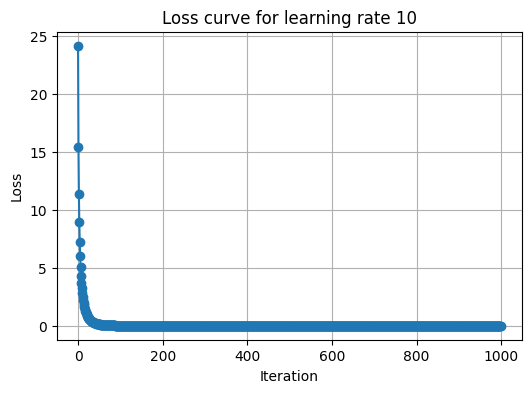

Learning rate: 100, losses: [24.16925811767578, 24.16925811767578, 4.146788597106934, 0.09924199432134628, 1.336870115417992e-16, 1.490024632424686e-18, 5.017437842615996e-20, 2.9889220257678576e-21, 2.5640905147008167e-22, 2.848989460778685e-23, 3.848670524134663e-24, 6.065157562829815e-25, 1.0834361118534776e-25, 2.1483662247978107e-26, 4.654850956811464e-27, 1.0886350788492933e-27, 2.7215876971232333e-28, 7.216332510613265e-29, 2.0163385126547413e-29, 5.9051175004518164e-30, 1.804443637664781e-30, 5.730997164637395e-31, 1.8855854501243589e-31, 6.408263289489364e-32, 2.2439818345844898e-32, 8.07833586816059e-33, 2.983988368800546e-33, 1.128985549490019e-33, 4.36836338215365e-34, 1.7261576641186132e-34, 6.95704794699966e-35, 2.8566412571808355e-35, 1.193771192980318e-35, 5.072351752956363e-36, 2.189494187988713e-36, 9.593537708959453e-37, 4.263794736611094e-37, 1.9208916392095504e-37, 8.766516466583427e-38, 4.05058297136868e-38, 1.893827268955243e-38, 8.95526548427443e-39, 4.280837889

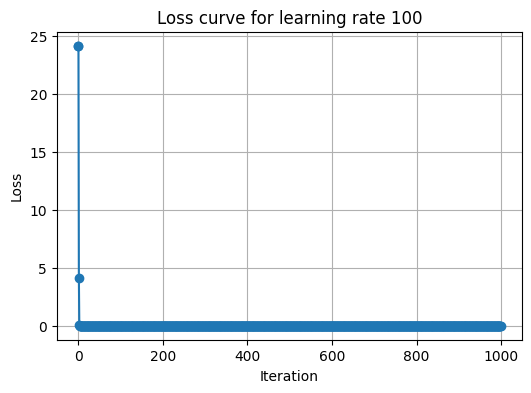

Learning rate: 1000, losses: [24.16925811767578, 8725.1015625, 1506962.5, 167633488.0, 13578311680.0, 856946966528.0, 43992855085056.0, 1892760814616576.0, 6.976313231409152e+16, 2.240171378709889e+18, 6.351085266071349e+19, 1.6070264919090319e+21, 3.661823489359366e+22, 7.570902614668709e+23, 1.4294603343646416e+25, 2.4784995531227155e+26, 3.965599284996345e+27, 5.880184963460066e+28, 8.111203917475619e+29, 1.0443988735829056e+31, 1.2590986589802755e+32, 1.4251617580367637e+33, 1.5183371720036368e+34, 1.5260393873400625e+35, 1.4499969100123343e+36, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,

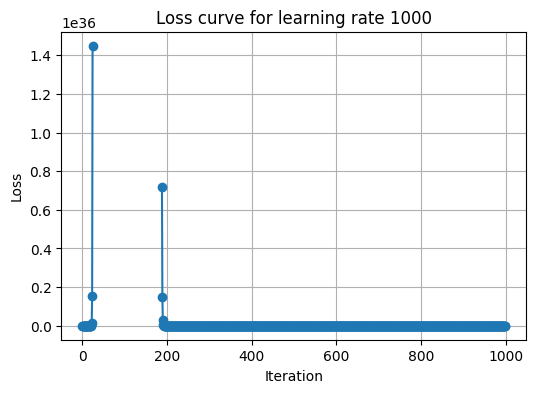

In [ ]:
import torch
import matplotlib.pyplot as plt
from cs336_basics.transformer.optimizer import SGD

lrs = [1e1, 1e2, 1e3]
loss_histories = {}

for lr in lrs:
    torch.manual_seed(42)  # for reproducibility

    weights = torch.nn.Parameter(5 * torch.randn((10, 10)))
    opt = SGD([weights], lr=lr)
    losses = []
    for t in range(1000):
        opt.zero_grad()  # Reset the gradients for all learnable parameters.
        loss = (weights**2).mean()  # Compute a scalar loss value.
        losses.append(loss.cpu().item())
        loss.backward()  # Run backward pass, which computes gradients.
        opt.step()  # Run optimizer step.
    loss_histories[lr] = losses

for lr, losses in loss_histories.items():
    print(f"Learning rate: {lr:g}, losses: {losses}")
    plt.figure(figsize=(6, 4))
    plt.plot(losses, marker="o")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(f"Loss curve for learning rate {lr:g}")
    plt.grid(True)
    plt.show()

### Problem (adamwAccounting): Resource accounting for training with AdamW
Let us compute how much memory and compute running AdamW requires. Assume we are using float32 for every tensor.  

[WARNING: 🆘 I HAVE NO IDEA WHAT I AM DOING!!!!]

#### (a) How much peak memory does running AdamW require? Decompose your answer based on the memory usage of the parameters, activations, gradients, and optimizer state. Express your answer in terms of the batch_size and the model hyperparameters (vocab_size, context_length, num_layers, d_model, num_heads). Assume d_ff = 4 × d_model.
For simplicity, when calculating memory usage of activations, consider only the following components:
- Transformer block
  - RMSNorm(s)
  - Multi-head self-attention sublayer: $QKV$ projections, $Q^{T}K$ matrix multiply, softmax, weighted sum of values, output projection.
  - Position-wise feed-forward: $W_1$ matrix multiply, SiLU, $W_2$ matrix multiply
- final RMSNorm
- output embedding
- cross-entropy on logits
Deliverable: An algebraic expression for each of parameters, activations, gradients, and optimizer state, as well as the total.

1. parameters:
- Embedding: $vocab\_size \times d\_model$
- Transformer blocks($num\_layers$):
  - RMSNorm: $d\_model$
  - RotaryPositionalEmbedding: $ d\_model // num\_heads \times context\_length$
  - CausalMultiHeadSelfAttention: $d\_model \times (3 \times d\_model) + d\_model \times d\_model = 4 \times d\_model \times d\_model$
  - RMSNorm: $d\_model$
  - SiLUFeedForward: $d\_model \times d\_ff + d\_ff \times d\_model$
- final RMSNorm: $d\_model$
- output embedding: $d\_model \times vocab\_size$

2. activations:
NOTE: not sure this is correct
- Transformer block($num\_layers$):
  - RMSNorm: $d\_model$
  - Multi-head self-attention sublayer: 
    - $QKV$ projections: $3 \times context\_length \times d\_model$
    - $Q^{T}K$ matrix multiply: $num\_heads \times context\_length \times context\_length$
    - softmax & weighted sum of values: $num\_heads \times context\_length \times context\_length$
    - output projection: $context\_length \times d\_model$
  - RMSNorm: $d\_model$
  - SiLUFeedForward: $d\_ff + d\_model$
- final RMSNorm: $d\_model$
- output embedding: $vocab\_size$
- cross-entropy on logits: $vocab\_size$

3. gradients
Each parameter has one gradient, so total memory of gradients is the same as parameters.

4. optimizer
AdamW maintains two state variables for each parameter: the first moment (m) and the second moment (v). Both are of the same shape as the parameter, so their memory usage is twice the parameter memory usage. Additionally, AdamW maintains a single scalar state variable (t) for each parameter.

#### (b) Instantiate your answer for a GPT-2 XL-shaped model to get an expression that only depends on the batch_size. What is the maximum batch size you can use and still fit within 80GB memory?
Deliverable: An expression that looks like a · batch_size + b for numerical values a, b, and a number representing the maximum batch size.  
- Parameters memory: $2*d\_model*vocab\_size + d\_model + num\_layers*(context\_length*floor(d\_model/num\_heads) + 12*d\_model**2 + 2*d\_model)$  
- Activations memory: $d\_model + num\_layers*(2*context\_length**2*num\_heads + 4*context\_length*d\_model + 7*d\_model) + 2*vocab\_size$  
- Gradients memory: $2*d\_model*vocab\_size + d\_model + num\_layers*(context\_length*floor(d\_model/num\_heads) + 12*d\_model**2 + 2*d\_model)$  
- Optimizer memory: $4*d\_model*vocab\_size + 2*d\_model + 2*num\_layers*(context\_length*floor(d\_model/num\_heads) + 12*d\_model**2 + 2*d\_model)$  
Total memory: $batch\_size*(d\_model + num\_layers*(2*context\_length**2*num\_heads + 4*context\_length*d\_model + 7*d\_model) + 2*vocab\_size) + 8*d\_model*vocab\_size + 4*d\_model + 4*num\_layers*(context\_length*floor(d\_model/num\_heads) + 12*d\_model**2 + 2*d\_model)$  
Instantiate for a GPT-2 XL-shaped model: 2831794914*batch_size + 6554733312  
approximately 5 can use and still fit within 80GB memory

#### (c) How many FLOPs does running one step of AdamW take?
Deliverable: An algebraic expression, with a brief justification.

Thrice the FLOPs of the forward pass.

#### (d) Model FLOPs utilization (MFU) is defined as the ratio of observed throughput (tokens per second) relative to the hardware's theoretical peak FLOP throughput [Chowdhery et al., 2022]. An NVIDIA A100 GPU has a theoretical peak of 19.5 teraFLOP/s for float32 operations. Assuming you are able to get 50% MFU, how long would it take to train a GPT-2 XL for 400K steps and a batch size of 1024 on a single A100? Following Kaplan et al. [2020] and Hoffmann et al. [2022], assume that the backward pass has twice the FLOPs of the forward pass.
Deliverable: The number of days training would take, with a brief justification.

Let:
- Forward pass FLOPs per batch: $F = 3,506,703,564,800$
- Total FLOPs per step (forward + backward): $3F = 10,520,110,694,400$
- Number of steps: $N = 400,000$
- Batch size: $B = 1024$
- Total FLOPs: $T = 3F \times N \times B$
- A100 theoretical peak: $19.5 \times 10^{12}$ FLOP/s
- Actual throughput (50% MFU): $9.75 \times 10^{12}$ FLOP/s

**Calculation:**

Total FLOPs:
$$
T = 10,520,110,694,400 \times 400,000 \times 1024 \approx 4.310 \times 10^{18}
$$

Total training time (seconds):
$$
\text{Time} = \frac{T}{9.75 \times 10^{12}} \approx 442,051 \text{ seconds}
$$

Convert to days:
$$
\frac{442,051}{86,400} \approx 5.1 \text{ days}
$$

**Justification:**  
Training GPT-2 XL for 400K steps with batch size 1024 on a single A100 at 50% MFU would take about **5.1 days**. This is based on the total compute required (forward + backward) and the effective hardware throughput.


In [25]:
import sympy as sp

from collections import namedtuple

ModelConfig = namedtuple(
    "ModelConfig", ["name", "vocab_size", "context_length", "num_layers", "d_model", "num_heads", "d_ff"]
)
GPT2_XL = ModelConfig(
    name="GPT2_XL", vocab_size=50257, context_length=1024, num_layers=48, d_model=1600, num_heads=25, d_ff=6400
)


def calculate_parameters_memory(vocab_size, d_model, num_layers, num_heads, d_ff, context_length):
    embedding = vocab_size * d_model

    rmsnorm1 = d_model
    rotary_pos_emb = (d_model // num_heads) * context_length
    causal_attn = 4 * d_model * d_model
    rmsnorm2 = d_model
    silu_ff = d_model * d_ff + d_ff * d_model
    transformer_block = rmsnorm1 + rotary_pos_emb + causal_attn + rmsnorm2 + silu_ff

    final_rmsnorm = d_model
    output_emb = d_model * vocab_size

    total_params = embedding + num_layers * transformer_block + final_rmsnorm + output_emb
    return total_params


# activation memory is associated with batch size
def calculate_activations_memory(vocab_size, d_model, num_layers, num_heads, d_ff, context_length):
    rmsnorm1 = d_model
    qkv_projections = 3 * context_length * d_model
    qk_t = num_heads * context_length * context_length
    attention_scores = num_heads * context_length * context_length
    output_projection = context_length * d_model
    rmsnorm2 = d_model
    silu_ff = d_ff + d_model

    transformer_block = rmsnorm1 + qkv_projections + qk_t + attention_scores + output_projection + rmsnorm2 + silu_ff

    final_rmsnorm = d_model
    output_emb = vocab_size
    cross_entropy = vocab_size

    total_activations = num_layers * transformer_block + final_rmsnorm + output_emb + cross_entropy
    return total_activations


def calculate_gradients_memory(vocab_size, d_model, num_layers, num_heads, d_ff, context_length):
    return calculate_parameters_memory(vocab_size, d_model, num_layers, num_heads, d_ff, context_length)


def calculate_optimizer_memory(vocab_size, d_model, num_layers, num_heads, d_ff, context_length):
    param_memory = calculate_parameters_memory(vocab_size, d_model, num_layers, num_heads, d_ff, context_length)
    return 2 * param_memory  # memory for `t` is left out


vocab_size, d_model, num_layers, num_heads, d_ff, context_length = sp.symbols(
    "vocab_size d_model num_layers num_heads d_ff context_length"
)
d_ff = 4 * d_model
parameters_memory = calculate_parameters_memory(vocab_size, d_model, num_layers, num_heads, d_ff, context_length)
print(f"Parameters memory: {sp.simplify(parameters_memory)}")

activations_memory = calculate_activations_memory(vocab_size, d_model, num_layers, num_heads, d_ff, context_length)
print(f"Activations memory: {sp.simplify(activations_memory)}")

gradients_memory = calculate_gradients_memory(vocab_size, d_model, num_layers, num_heads, d_ff, context_length)
print(f"Gradients memory: {sp.simplify(gradients_memory)}")

optimizer_memory = calculate_optimizer_memory(vocab_size, d_model, num_layers, num_heads, d_ff, context_length)
print(f"Optimizer memory: {sp.simplify(optimizer_memory)}")

batch_size = sp.symbols("batch_size")
total_memory = parameters_memory + batch_size * activations_memory + gradients_memory + optimizer_memory
print(f"Total memory: {sp.simplify(total_memory)}")

for config in [GPT2_XL]:
    print(f"Config: {config}")
    result = total_memory.subs(
        {
            vocab_size: config.vocab_size,
            d_model: config.d_model,
            num_layers: config.num_layers,
            num_heads: config.num_heads,
            d_ff: config.d_ff,
            context_length: config.context_length,
        }
    )
    print(f"Result: {result}")
    max_mem_bytes = 80 * 1024**3
    eq = sp.Eq(4 * result, max_mem_bytes)
    sol = sp.solve(eq, batch_size)
    print(f"Max batch size: {sol[0]}, approximately {int(sol[0])}")
    print("\n" + "=" * 50 + "\n")

Parameters memory: 2*d_model*vocab_size + d_model + num_layers*(context_length*floor(d_model/num_heads) + 12*d_model**2 + 2*d_model)
Activations memory: d_model + num_layers*(2*context_length**2*num_heads + 4*context_length*d_model + 7*d_model) + 2*vocab_size
Gradients memory: 2*d_model*vocab_size + d_model + num_layers*(context_length*floor(d_model/num_heads) + 12*d_model**2 + 2*d_model)
Optimizer memory: 4*d_model*vocab_size + 2*d_model + 2*num_layers*(context_length*floor(d_model/num_heads) + 12*d_model**2 + 2*d_model)
Total memory: batch_size*(d_model + num_layers*(2*context_length**2*num_heads + 4*context_length*d_model + 7*d_model) + 2*vocab_size) + 8*d_model*vocab_size + 4*d_model + 4*num_layers*(context_length*floor(d_model/num_heads) + 12*d_model**2 + 2*d_model)
Config: ModelConfig(name='GPT2_XL', vocab_size=50257, context_length=1024, num_layers=48, d_model=1600, num_heads=25, d_ff=6400)
Result: 2831794914*batch_size + 6554733312
Max batch size: 7460051584/1415897457, approxi

In [ ]:
import os
import time
import numpy as np
from cs336_basics.bpe_tokenizer.encoder import load_bpe_tokenizer


data_path = f"data/TinyStoriesV2-GPT4-train_encoded_10k.npy"

vocab_filepath = "data/TinyStoriesV2-GPT4_vocab.json"
merge_filepath = "data/TinyStoriesV2-GPT4_merges.txt"

tokenizer = load_bpe_tokenizer(
    vocab_path=vocab_filepath,
    merge_path=merge_filepath,
    special_tokens=["<|endoftext|>"],
)

array = np.memmap(data_path, dtype=np.uint16, mode="r")

assert array.max() < 10000